# Imports 

In [1]:
%matplotlib inline
import numpy as np
import cv2
from incisorseg.dataset import Dataset,LeaveOneOutSplitter,load_image,load_landmark,gaussian_pyramid_down
from incisorseg.utils import *
from active_shape_models.shape import Shape, ShapeList
from active_shape_models.models import AppearanceModel, GreyModel,PointDistributionModel,ActiveShapeModel
from active_shape_models.pca import PCAModel

In [24]:
l = list(zip(*[(1,2),(3,4),(5,6)]))
print l

[(1, 3, 5), (2, 4, 6)]


# Reading data

In [2]:
data = Dataset('../data/')

# Appearance Model

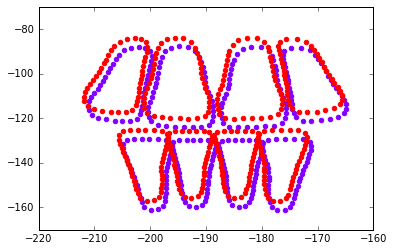

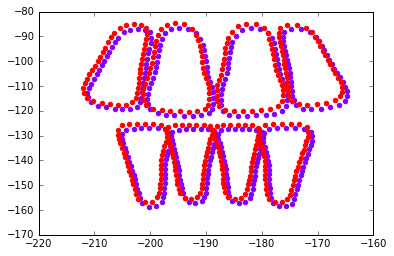

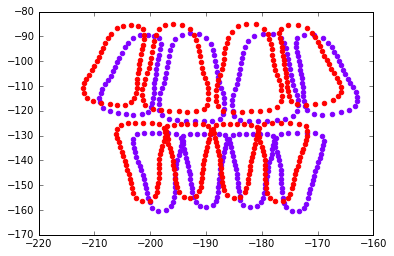

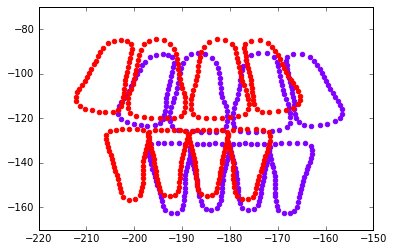

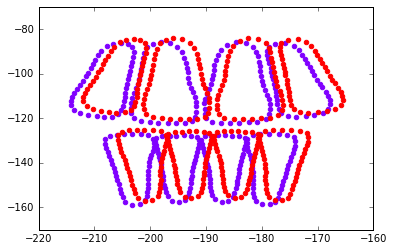

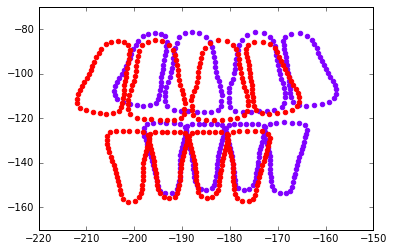

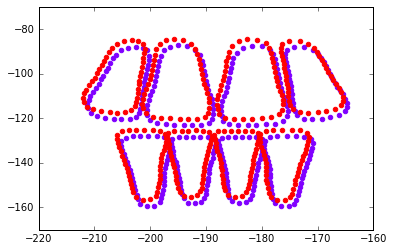

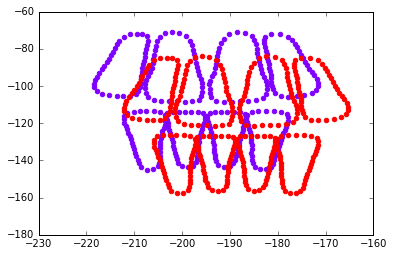

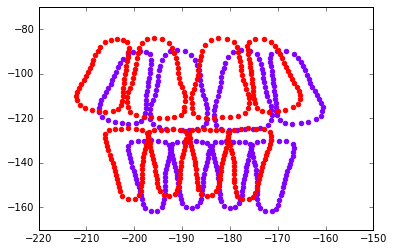

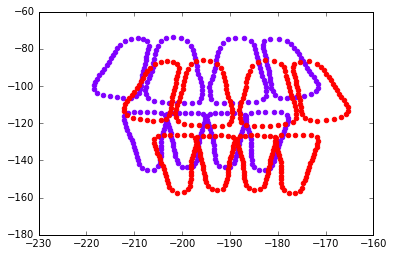

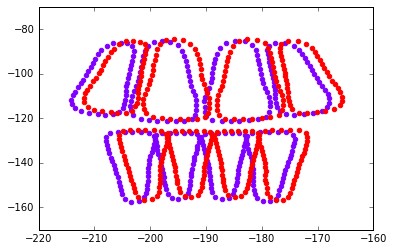

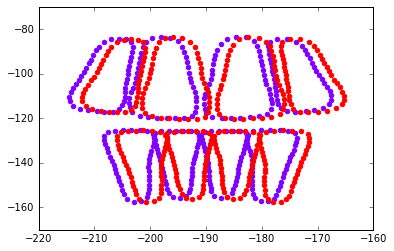

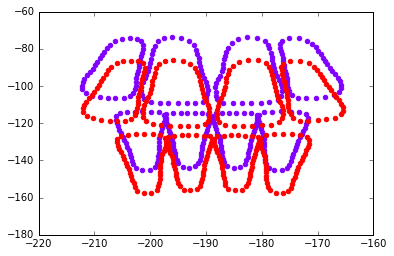

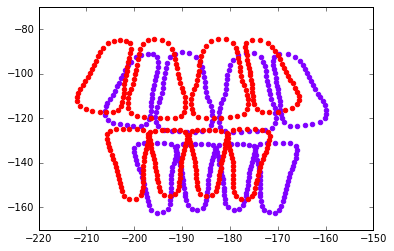

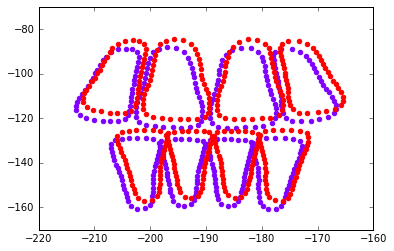

In [8]:
'''
pyr_levels = 4
for split in LeaveOneOutSplitter(data):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    scaled_training_images,scaled_training_landmarks = gaussian_pyramid_down(
        training_images,num_levels=pyr_levels, training_landmarks=training_landmarks)
    scaled_test_image = gaussian_pyramid_down([test_image],num_levels=pyr_levels)[0]
    #scaled_training_images = [cv2.equalizeHist(img) for img in scaled_training_images]
    #scaled_test_image = cv2.equalizeHist(scaled_test_image)
    shape_model = PointDistributionModel(scaled_training_landmarks)
    #print shape_model.get_mean_shape_projected().get_centroid()
    app_model = AppearanceModel(scaled_training_images,shape_model,[6,6])
    shape= app_model.fit(scaled_test_image)
    #plot_shapes([shape,shape_model.get_mean_shape_projected()])
    imshow2(overlay_shapes_on_image(scaled_test_image,[shape,shape_model.get_mean_shape_projected()]))
'''

# Point Distribution Model

In [4]:
'''
lc,mlc = data.get_training_image_landmarks(Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH)
landmarks = lc.concatenate(mlc)
model = PointDistributionModel(landmarks)
plot_shapes(model.get_aligned_shapes())
plot_shapes([model.get_mean_shape()])
plot_shapes(model.generate_mode_shapes(1))
plot_shapes(model.generate_mode_shapes(2))
plot_shapes(model.generate_mode_shapes(3))
'''

'\nlc,mlc = data.get_training_image_landmarks(Dataset.ALL_TRAINING_IMAGES,Dataset.ALL_TEETH)\nlandmarks = lc.concatenate(mlc)\nmodel = PointDistributionModel(landmarks)\nplot_shapes(model.get_aligned_shapes())\nplot_shapes([model.get_mean_shape()])\nplot_shapes(model.generate_mode_shapes(1))\nplot_shapes(model.generate_mode_shapes(2))\nplot_shapes(model.generate_mode_shapes(3))\n'

# Ideal case - testing the shape model fitting

In [5]:
'''
errors = []
for split in LeaveOneOutSplitter(data):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    shape_model = PointDistributionModel(training_landmarks,pca_variance_captured=0.98)
    fitted_shape,_,num_iters =shape_model.fit(test_landmark)
    errors.append(split.get_dice_error_on_test(fitted_shape))
print np.mean(np.array(errors))
'''

'\nerrors = []\nfor split in LeaveOneOutSplitter(data):\n    training_images,training_landmarks,training_segmentations = split.get_training_set()\n    test_image,test_landmark,test_segmentation = split.get_test_example()\n    shape_model = PointDistributionModel(training_landmarks,pca_variance_captured=0.98)\n    fitted_shape,_,num_iters =shape_model.fit(test_landmark)\n    errors.append(split.get_dice_error_on_test(fitted_shape))\nprint np.mean(np.array(errors))\n'

# Ideal case - testing the grey model fitting

5


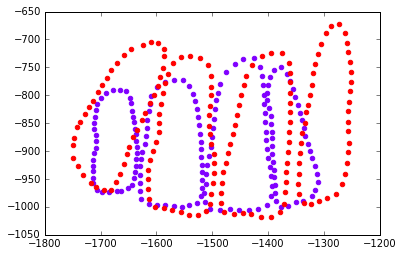

8


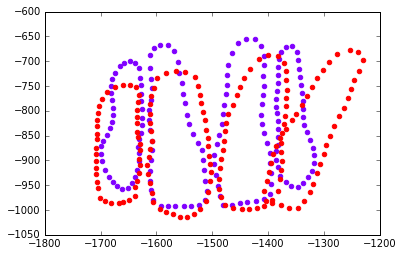

2


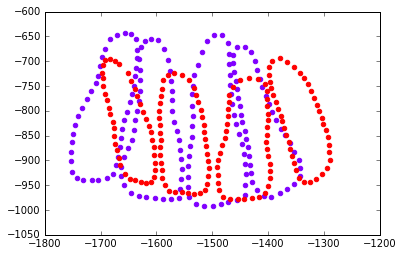

13


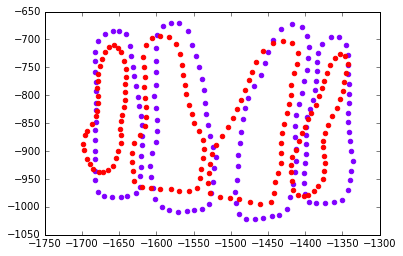

16


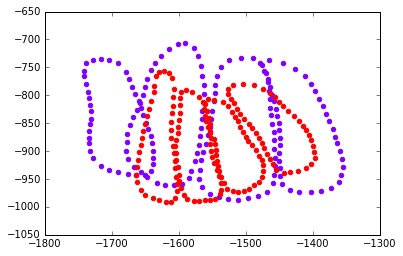

15


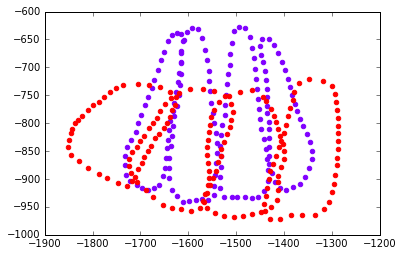

4


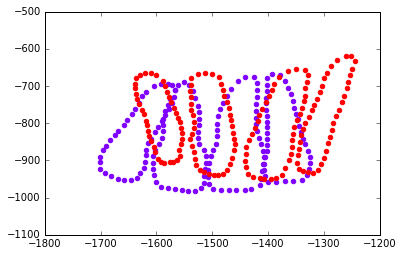

0


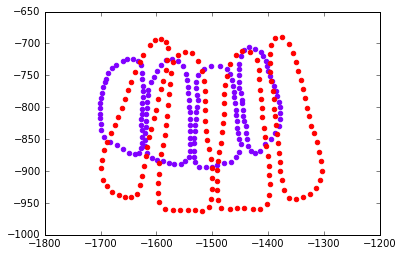

5


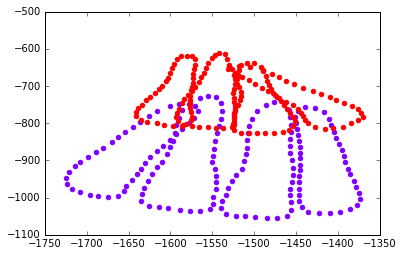

3


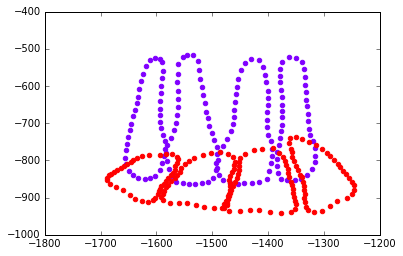

10


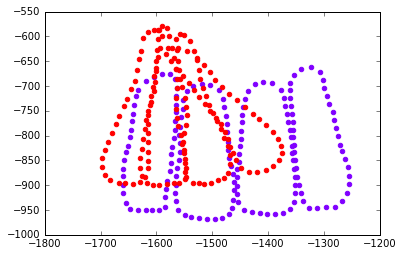

19


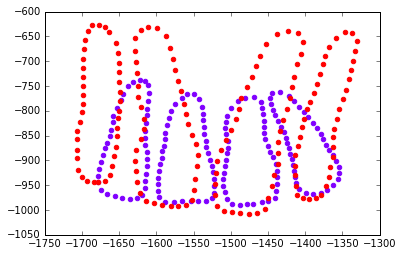

2


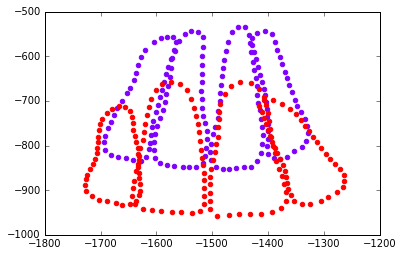

45


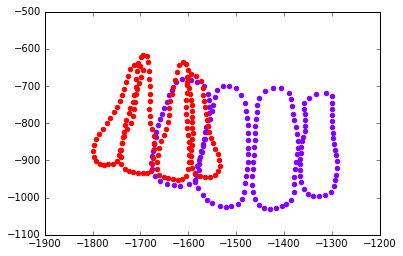

5


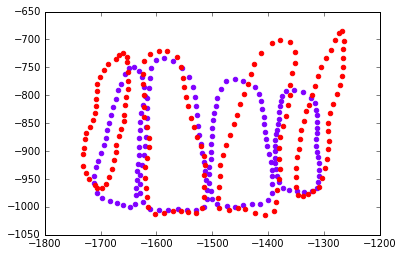

nan


In [21]:
pyr_levels=0
error_list = []
for split in LeaveOneOutSplitter(data):
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    scaled_training_images,scaled_training_landmarks = gaussian_pyramid_down(
        training_images,num_levels=pyr_levels, training_landmarks=training_landmarks)
    scaled_test_image,scaled_test_landmark = gaussian_pyramid_down([test_image],training_landmarks=[test_landmark],num_levels=pyr_levels)
    scaled_test_image = scaled_test_image[0]
    scaled_test_landmark = scaled_test_landmark[0]
    all_teeth_shape_model = PointDistributionModel(scaled_training_landmarks,pca_variance_captured=0.99)
    all_teeth_app_model = AppearanceModel(scaled_training_images,all_teeth_shape_model,[6,6])
    fitted_shape_appearance = all_teeth_app_model.fit(transformed_test_image)
    secondary_split_landmarks = list(zip(*[tuple(ShapeList.from_shape(shape,2)) for shape in scaled_training_landmarks]))
    upper_teeth_initial_position,lower_teeth_initial_position = tuple(ShapeList.from_shape(fitted_shape_appearance,2))
    upper_teeth_test_landmark,lower_teeth_test_landmark = tuple(ShapeList.from_shape(scaled_test_landmark,2))
    upper_teeth_training_landmarks,lower_teeth_training_landmarks = 
    upper_teeth_shape_model = PointDistributionModel(upper_teeth_training_landmarks,pca_variance_captured=0.9)
    lower_teeth_shape_model = PointDistributionModel(lower_teeth_training_landmarks,pca_variance_captured=0.9)
    transformed_test_image = scaled_test_image
    transformed_training_images = scaled_training_images
    #transformed_training_images = [cv2.Laplacian(image,ddepth=cv2.CV_32F) for image in scaled_training_images]
    #transformed_test_image = cv2.Laplacian(scaled_test_image,ddepth=cv2.CV_32F)
    transformed_training_images = [cv2.medianBlur(image,3) for image in scaled_training_images]
    transformed_test_image = cv2.medianBlur(scaled_test_image,3)
    grey_model = GreyModel(transformed_training_images, upper_teeth_training_landmarks,patch_num_pixels=5*(5-pyr_levels), 
                           search_num_pixels=40*(5-pyr_levels), use_gradient=True,
                 normalize_patch=True, use_moded_pca_model=False, mpca_variance_captured=0.9,
                 normal_point_neighborhood=1)
    model=ActiveShapeModel(grey_model=grey_model,point_distribution_model=upper_teeth_shape_model,appearance_model=None)
    new_shape,fit_error,num_iters = model.fit(scaled_test_image,0.2,100, initial_shape=upper_teeth_initial_position)
    print num_iters
    plot_shapes([upper_teeth_test_landmark,new_shape])
    #fitted_shape_grey,_ =grey_model.search(transformed_test_image,upper_teeth_initial_position.round())
    #fitted_shape,_,_=upper_teeth_shape_model.fit(fitted_shape_grey)
    #fitted_shape_grey,_ =grey_model.search(transformed_test_image,fitted_shape.round())
    #fitted_shape,_,_=upper_teeth_shape_model.fit(fitted_shape_grey)
    #plot_shapes([upper_teeth_test_landmark,fitted_shape_grey,fitted_shape])
    #for j in range(0,pyr_levels):
    #    fitted_shape = fitted_shape.pyr_up()
    #error_list.append(split.get_dice_error_on_test(fitted_shape))
    #plot_shapes([test_landmark,fitted_shape])
print np.mean(np.array(error_list))

In [7]:
'''
i = 0
pyr_levels = 4
for split in LeaveOneOutSplitter(data):
    if i >=1:
        pass#break
    training_images,training_landmarks,training_segmentations = split.get_training_set()
    test_image,test_landmark,test_segmentation = split.get_test_example()
    scaled_training_images = []
    scaled_training_landmarks = []
    scaled_test_images = []
    scaled_test_landmarks = []
    scaled_training_images.append(training_images)
    scaled_training_landmarks.append(ShapeList([ShapeList.from_shape(landmark,1)[0] for landmark in training_landmarks]))
    scaled_test_images.append(test_image)
    scaled_test_landmarks.append(ShapeList.from_shape(test_landmark,1)[0])
    for j in range(1,pyr_levels):
        scaled_test_images.append(cv2.pyrDown(scaled_test_images[j-1]))
        scaled_test_landmarks.append(scaled_test_landmarks[j-1].pyr_down())
        scaled_training_images.append([cv2.pyrDown(image) for image in scaled_training_images[j-1]])
        scaled_training_landmarks.append(ShapeList([shape.pyr_down() for shape in scaled_training_landmarks[j-1]]))
    new_shape = None
    #print 'Test Landmarks Accuracy %f',split.get_dice_error_on_test(test_landmark)
    detected_shapes = []
    for j in range(pyr_levels-1,-1,-1):
        shape_model = PointDistributionModel(scaled_training_landmarks[j],pca_variance_captured=0.9)
        grey_model = GreyModel(scaled_training_images[j],scaled_training_landmarks[j],
                               patch_num_pixels=5*(pyr_levels-j),
                               search_num_pixels=7*(pyr_levels-j))
        app_model = AppearanceModel(scaled_training_images[j],shape_model,[6,6])
        model = ActiveShapeModel(grey_model=grey_model,point_distribution_model=shape_model,appearance_model=app_model)
        new_shape,fit_error,num_iters = model.fit(scaled_test_images[j],0.5,100, initial_shape=new_shape)
        if j == pyr_levels-1:     
            detected_shapes.append(model.get_default_initial_shape())
        detected_shapes.append(new_shape)
        if j == 0:
            imshow2(overlay_shapes_on_image(scaled_test_images[j],[new_shape.round()]))
        #plot_shapes([new_shape])
        new_shape = new_shape.pyr_up()
    i +=1
    for j in range(len(detected_shapes)):
        if j==0:
            scale_start = 1
        else:
            scale_start = j
        for k in range(scale_start,pyr_levels):
            detected_shapes[j]=detected_shapes[j].pyr_up()
        
        #print 'Level:' , j, 'Accuracy',split.get_dice_error_on_test(detected_shapes[j]) 
'''

"\ni = 0\npyr_levels = 4\nfor split in LeaveOneOutSplitter(data):\n    if i >=1:\n        pass#break\n    training_images,training_landmarks,training_segmentations = split.get_training_set()\n    test_image,test_landmark,test_segmentation = split.get_test_example()\n    scaled_training_images = []\n    scaled_training_landmarks = []\n    scaled_test_images = []\n    scaled_test_landmarks = []\n    scaled_training_images.append(training_images)\n    scaled_training_landmarks.append(ShapeList([ShapeList.from_shape(landmark,1)[0] for landmark in training_landmarks]))\n    scaled_test_images.append(test_image)\n    scaled_test_landmarks.append(ShapeList.from_shape(test_landmark,1)[0])\n    for j in range(1,pyr_levels):\n        scaled_test_images.append(cv2.pyrDown(scaled_test_images[j-1]))\n        scaled_test_landmarks.append(scaled_test_landmarks[j-1].pyr_down())\n        scaled_training_images.append([cv2.pyrDown(image) for image in scaled_training_images[j-1]])\n        scaled_trainin